## Graph Neural Network Property Predictor


## Imports

In [1]:
# Working on segmenting from monolithic structure as this file is getting too lengthy
from model import GNN
from utils.config import FEATURE_NAMES, GRAPH_METRICS, RESIDUAL_G_FEATURES
from utils.visualization import VisualizationManager
import utils.data_utils as DataUtils

c:\Users\Will\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Execution


Data Processing Debug:
Number of nodes: 100
Number of features: 46
Feature tensor shape: torch.Size([100, 46])
Edge index shape: torch.Size([2, 231])
Target value: -0.0500807985663414
Selected nodes: [69, 6, 14, 20]

Data Processing Debug:
Number of nodes: 100
Number of features: 46
Feature tensor shape: torch.Size([100, 46])
Edge index shape: torch.Size([2, 240])
Target value: -0.06337495893239975
Selected nodes: [78, 3, 56, 60]

Data Processing Debug:
Number of nodes: 99
Number of features: 46
Feature tensor shape: torch.Size([99, 46])
Edge index shape: torch.Size([2, 231])
Target value: -0.0500807985663414
Selected nodes: [29, 5, 28, 86]

Data Processing Debug:
Number of nodes: 99
Number of features: 46
Feature tensor shape: torch.Size([99, 46])
Edge index shape: torch.Size([2, 240])
Target value: -0.06337495893239975
Selected nodes: [30, 29, 46, 6]
Epoch   0: Train Loss = 1.1167, Test Loss = 0.1264

Data Processing Debug:
Number of nodes: 99
Number of features: 46
Feature tensor s

c:\Users\Will\miniforge3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([99, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Data Processing Debug:
Number of nodes: 99
Number of features: 46
Feature tensor shape: torch.Size([99, 46])
Edge index shape: torch.Size([2, 240])
Target value: -0.06337495893239975
Selected nodes: [77, 1, 67, 81]

Data Processing Debug:
Number of nodes: 99
Number of features: 46
Feature tensor shape: torch.Size([99, 46])
Edge index shape: torch.Size([2, 231])
Target value: -0.0500807985663414
Selected nodes: [51, 3, 6, 27]

Data Processing Debug:
Number of nodes: 99
Number of features: 46
Feature tensor shape: torch.Size([99, 46])
Edge index shape: torch.Size([2, 240])
Target value: -0.06337495893239975
Selected nodes: [28, 21, 2, 22]

Data Processing Debug:
Number of nodes: 99
Number of features: 46
Feature tensor shape: torch.Size([99, 46])
Edge index shape: torch.Size([2, 231])
Target value: -0.0500807985663414
Selected nodes: [73, 9, 39, 72]

Data Processing Debug:
Number of nodes: 99
Number of features: 46
Feature tensor shape: torch.Size([99, 46])
Edge index shape: torch.Size(

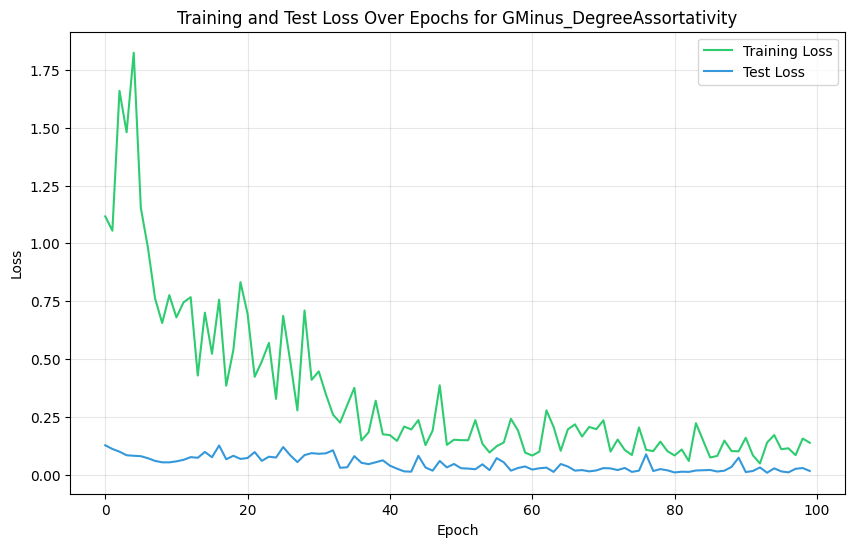


Final Test Metrics:
test_loss: 0.0599
mae: 0.2031
r2_score: -inf


c:\Users\Will\miniforge3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [2]:
# Generate different graphs for training and test to test generalization
G_train, selected_nodes_train = DataUtils.generate_graph(num_nodes=100, edge_prob=0.05)
G_test, selected_nodes_test = DataUtils.generate_graph(num_nodes=100, edge_prob=0.05)

# Select target feature for analysis.
target_feature = "GMinus_DegreeAssortativity"

# Make sure the user only selects a feature in P(G/G')
if target_feature not in RESIDUAL_G_FEATURES:
    raise ValueError(
        f"Invalid target feature: {target_feature}\n"
        f"Target feature must be one of the following G/G' metrics:\n"
        f"{', '.join(RESIDUAL_G_FEATURES)}"
    )

target_idx = RESIDUAL_G_FEATURES.index(target_feature)

train_data = DataUtils.process_graph_data(G_train, selected_nodes_train, target_idx)
test_data = DataUtils.process_graph_data(G_test, selected_nodes_test, target_idx)

model = GNN(node_feature_dim=len(FEATURE_NAMES))

losses, trained_model = model.train_model(
    model, 
    train_data=train_data,
    test_data=test_data, 
    target_idx=target_idx
)

# Plot training progress
vis = VisualizationManager()
vis.plot_training_progress(
    train_losses=[loss['train_loss'] for loss in losses],
    test_losses=[loss['test_loss'] for loss in losses],
    title="Training and Test Loss Over Epochs for " + target_feature
)

# Get final test metrics
test_metrics = trained_model.evaluate(test_data, target_idx)
print("\nFinal Test Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")